## Phase 4 Data Mining
In this notebook we use machine learning to analyze the detection of each of the Modbus Protocol attacks: 
- Arp-based Man in the Middle (mitm)
- TCP SYN flooding
- Modbus Query flood
- Ping flooding

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
import matplotlib.pyplot as plt

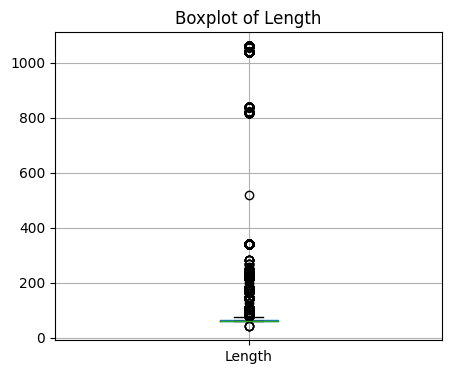

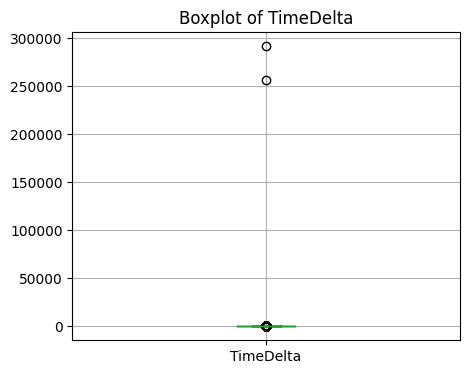

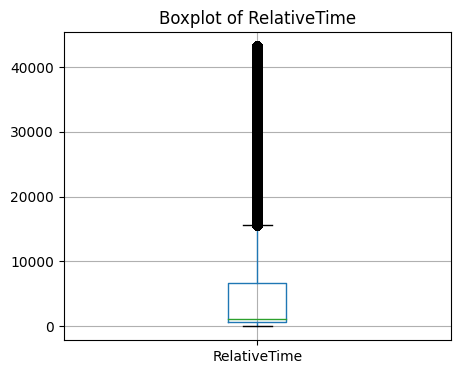

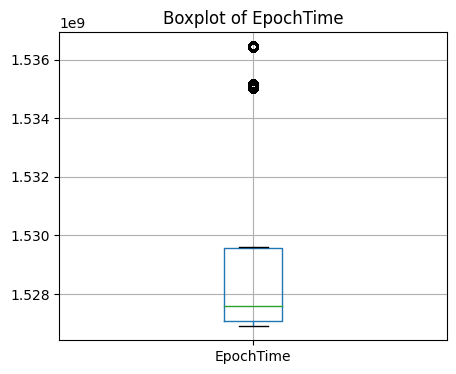

In [13]:

# Load the datasets
files = ['clean.csv', 'mitm.csv', 'modbusQuery2Flooding.csv', 'modbusQueryFlooding.csv', 'pingFloodDDos.csv', 'tcpSYNFlood.csv']
data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


relevant_features = ['Length',
                    'Protocol',
                    'SrcPort',
                    'DstPort',
                    'SYNFlag',
                    'ACKFlag',
                    'TimeDelta',
                    'RelativeTime', 
                    'EpochTime',
                    'AttackName']

data = data[relevant_features]

import matplotlib.pyplot as plt

numeric_features = [
    "Length",
    "TimeDelta",
    "RelativeTime",
    "EpochTime",
]

# For each column in the DataFrame
for column in numeric_features:
    # Create a boxplot
    plt.figure(figsize=(5, 4))
    data.boxplot([column])
    plt.title(f"Boxplot of {column}")
    plt.show()


epoch timestamp does not change in relation to the attack type

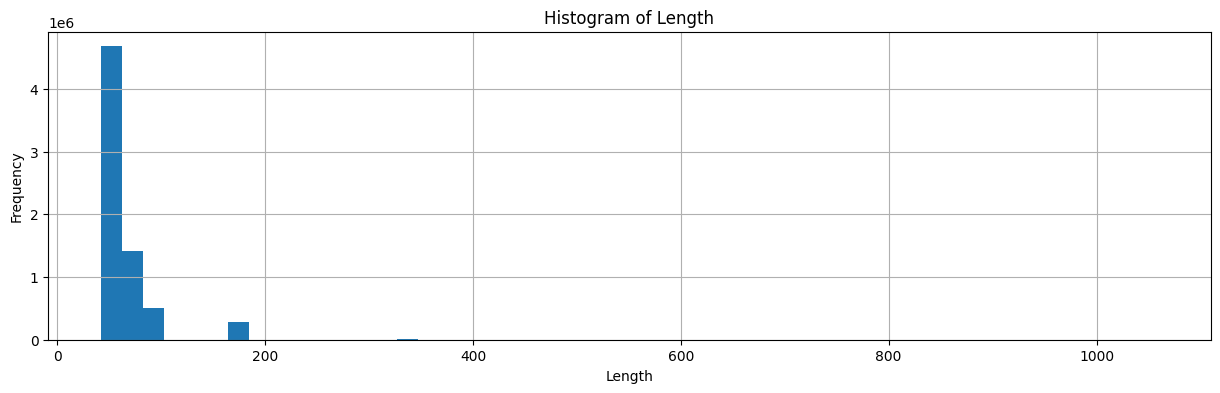

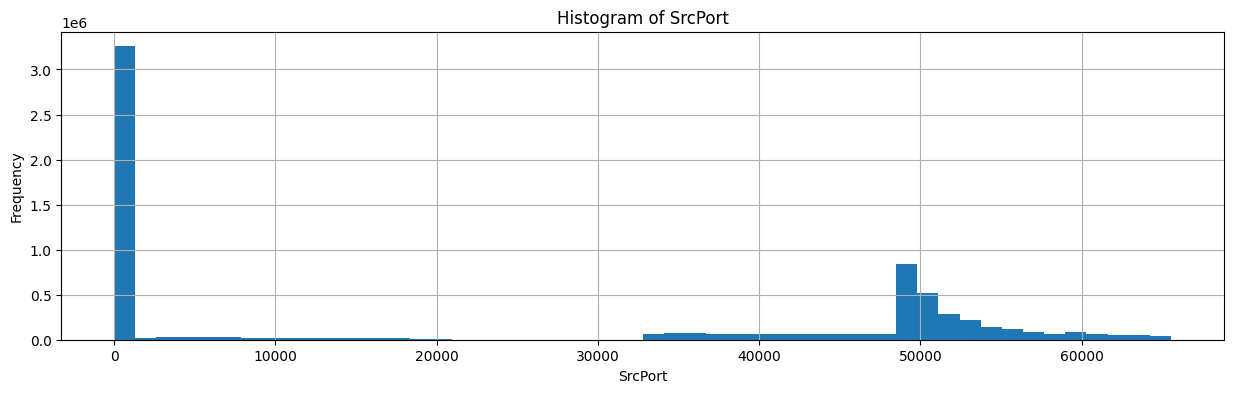

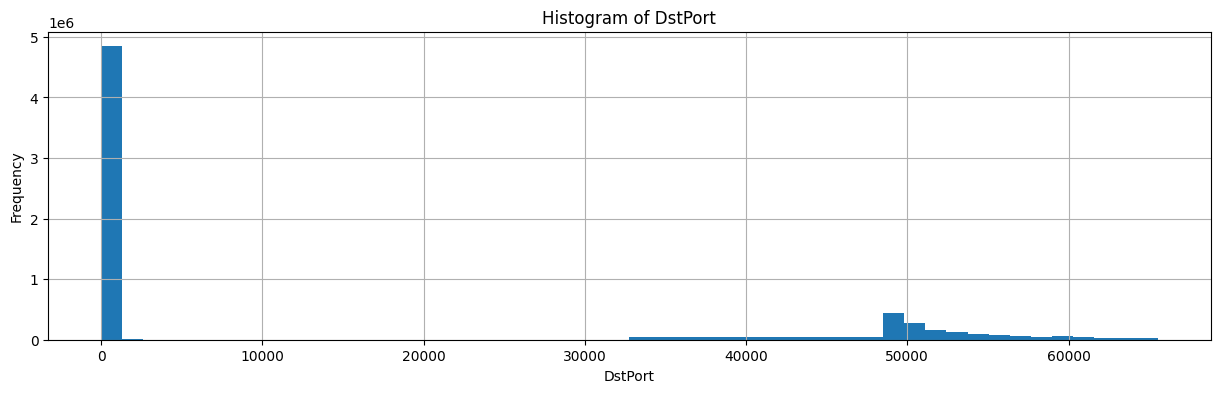

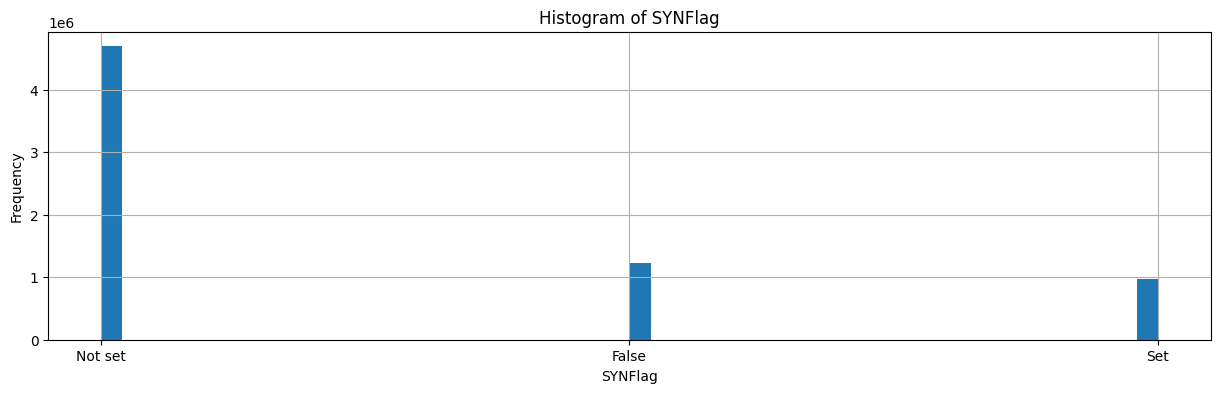

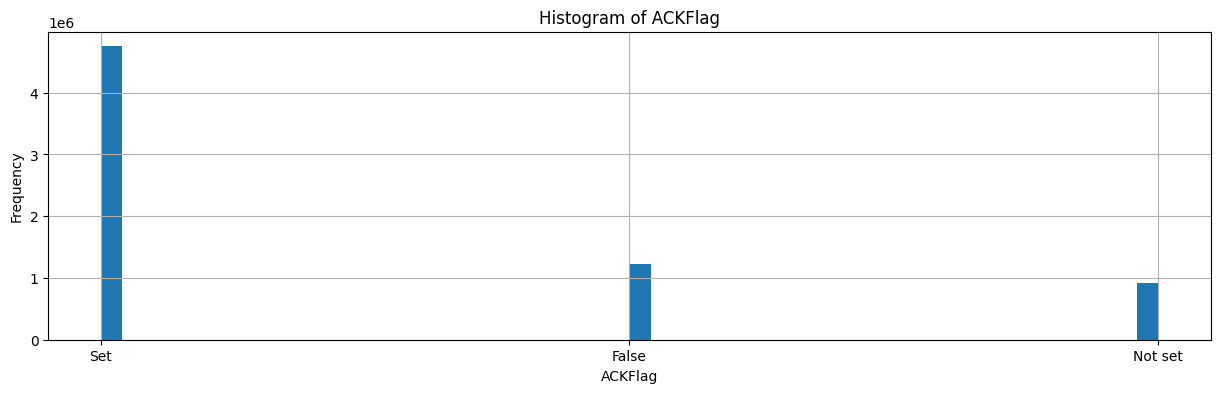

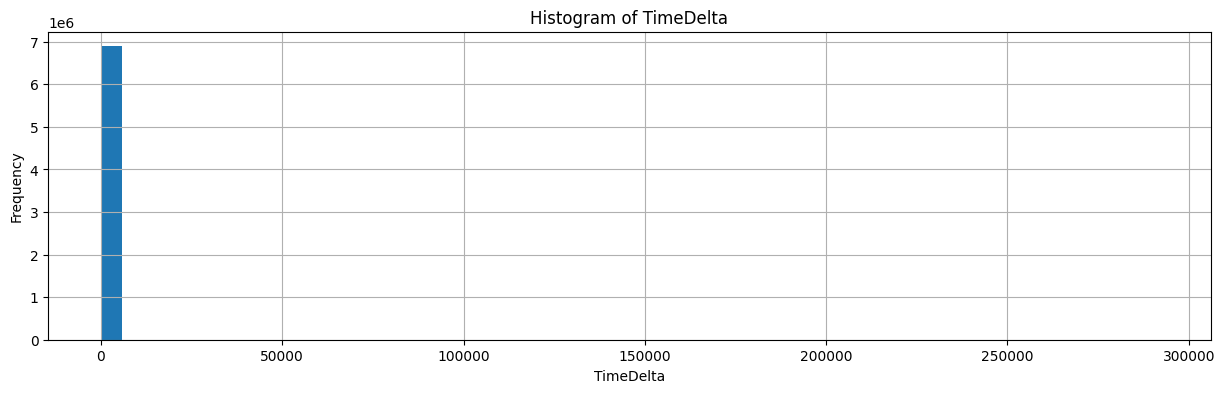

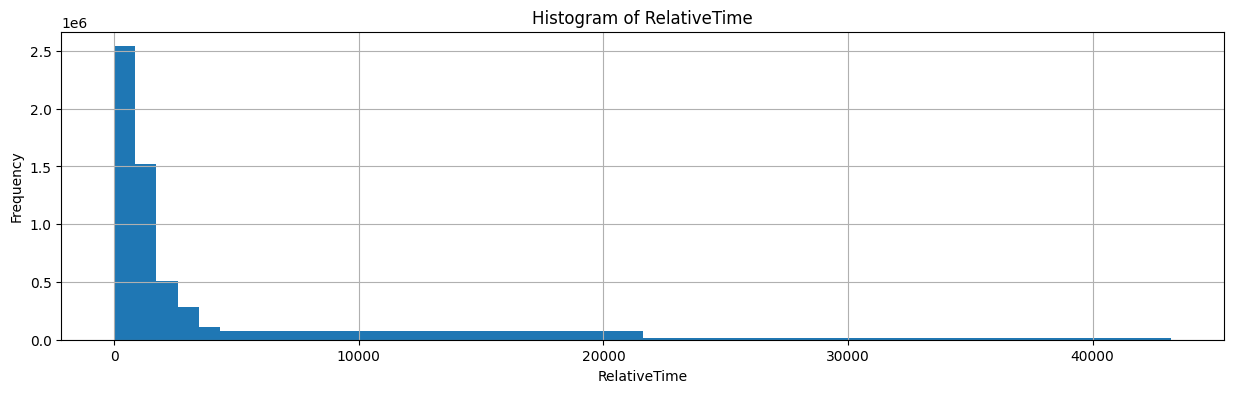

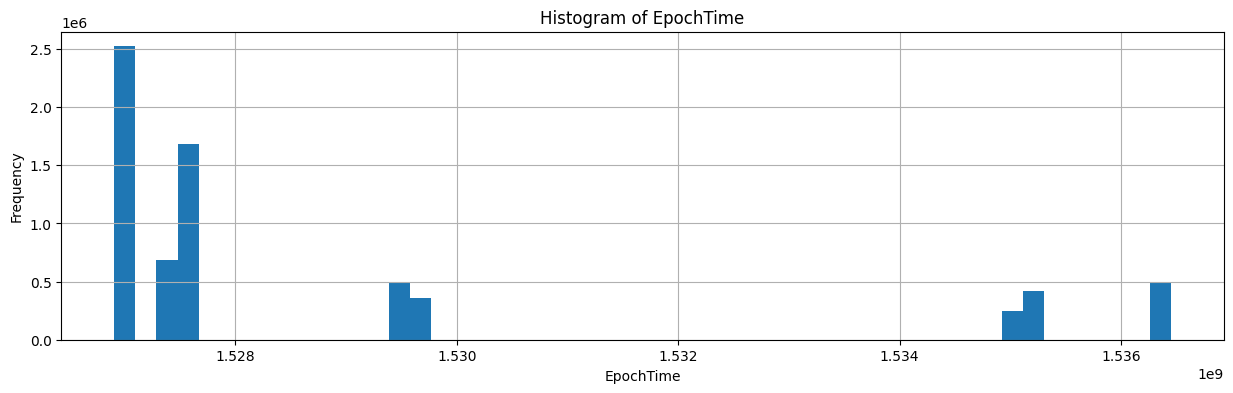

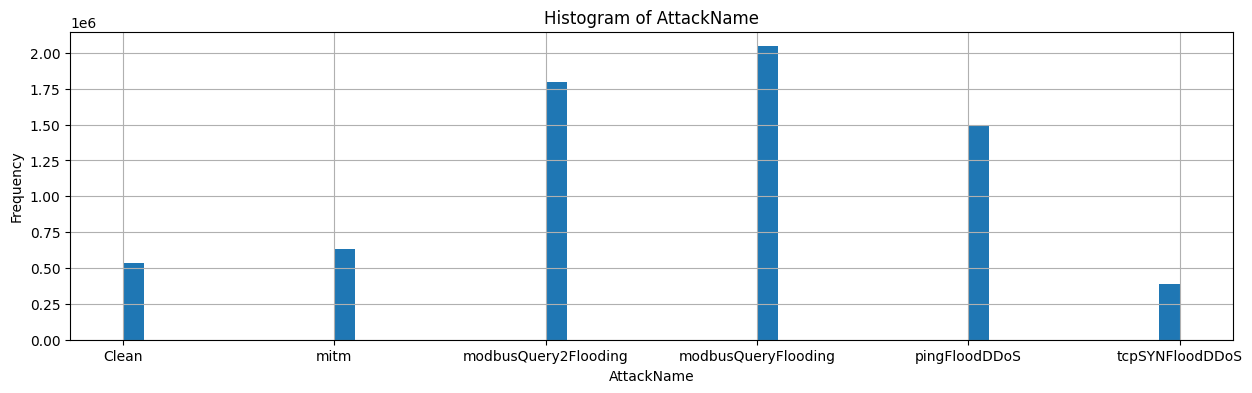

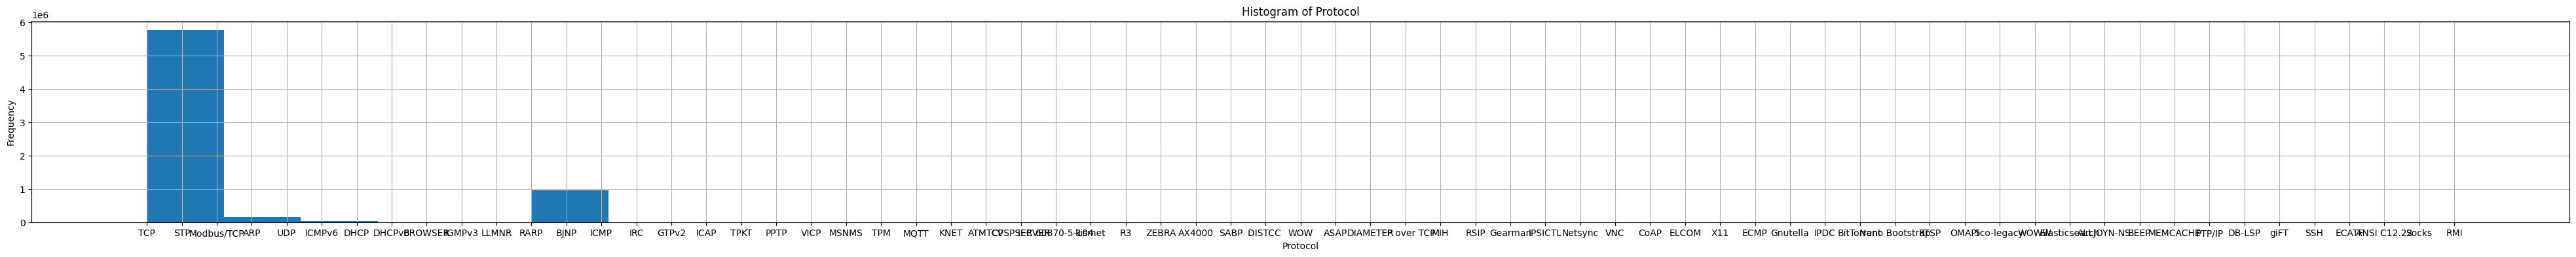

In [21]:
# For each column in the DataFrame
for column in data.columns:
    # Create a histogram
    if column == "Protocol": 
        continue
    plt.figure(figsize=(15, 4))
    data[column].hist(bins=50)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

plt.figure(figsize=(50, 4))
data['Protocol'].hist(bins=30)
plt.title(f"Histogram of Protocol")
plt.xlabel('Protocol')
plt.ylabel("Frequency")
plt.show()

In [4]:

# verify the unique values for the attacks
print("Unique values in 'AttackName' before mapping:", data['AttackName'].unique())

   Length    Protocol  SrcPort  DstPort  SYNFlag ACKFlag  TimeDelta  \
0      60         TCP  49499.0    502.0  Not set     Set   0.000000   
1      64         STP     -1.0     -1.0    False   False   0.020940   
2      66  Modbus/TCP  49499.0    502.0  Not set     Set   0.073369   
3      85  Modbus/TCP    502.0  49499.0  Not set     Set   0.003118   
4      60         TCP  49499.0    502.0  Not set     Set   0.214545   

   RelativeTime     EpochTime AttackName  
0      0.000000  1.535046e+09      Clean  
1      0.020940  1.535046e+09      Clean  
2      0.094309  1.535046e+09      Clean  
3      0.097427  1.535046e+09      Clean  
4      0.311972  1.535046e+09      Clean  
Columns in loaded data: Index(['Length', 'Protocol', 'SrcPort', 'DstPort', 'SYNFlag', 'ACKFlag',
       'TimeDelta', 'RelativeTime', 'EpochTime', 'AttackName'],
      dtype='object')
Unique values in 'AttackName' before mapping: ['Clean' 'mitm' 'modbusQuery2Flooding' 'modbusQueryFlooding'
 'pingFloodDDoS' 'tcpSYNF

In [5]:
# mapping dictionary, using label encoding to convert the attack names to integers
attack_name_mapping = {
    'Clean': 1,  
    'mitm': 2,
    'modbusQuery2Flooding': 3,
    'modbusQueryFlooding': 4,
    'pingFloodDDoS': 5,
    'tcpSYNFloodDDoS': 6
}

# Apply the mapping
data['AttackName'] = data['AttackName'].map(attack_name_mapping)

# Check the results of the mapping
print("Unique values in 'AttackName' after mapping:", data['AttackName'].unique())
print("Non-null values in 'AttackName' after mapping:", data['AttackName'].notnull().sum()) # total number of rows in 'AttackName' column that don't have null values
print("Null values in 'AttackName':", data['AttackName'].isnull().sum())


Unique values in 'AttackName' after mapping: [1 2 3 4 5 6]
Non-null values in 'AttackName' after mapping: 6889976
Null values in 'AttackName': 0


In [6]:
print("Unique values in 'Source Port':", data['SrcPort'].nunique())
print("Unique values in 'Destination Port':", data['DstPort'].nunique())

# deciding to proceed with label encoding, instead of one-hot to avoid increasing the dimensionality of the data

Unique values in 'Source Port': 57862
Unique values in 'Destination Port': 23904


In [7]:
categorical_features = ['Protocol', 'SrcPort', 'DstPort', 'SYNFlag', 'ACKFlag']
#label_encoder = LabelEncoder()
for col in categorical_features:
    print(data[col])
    #= label_encoder.fit_transform(data[col].astype(str)) # convert the column value to string before encoding

0                 TCP
1                 STP
2          Modbus/TCP
3          Modbus/TCP
4                 TCP
              ...    
6889971    Modbus/TCP
6889972           TCP
6889973           STP
6889974           TCP
6889975           TCP
Name: Protocol, Length: 6889976, dtype: object
0          49499.0
1             -1.0
2          49499.0
3            502.0
4          49499.0
            ...   
6889971      502.0
6889972    50084.0
6889973       -1.0
6889974    50084.0
6889975      502.0
Name: SrcPort, Length: 6889976, dtype: float64
0            502.0
1             -1.0
2            502.0
3          49499.0
4            502.0
            ...   
6889971    50084.0
6889972      502.0
6889973       -1.0
6889974      502.0
6889975    50084.0
Name: DstPort, Length: 6889976, dtype: float64
0          Not set
1            False
2          Not set
3          Not set
4          Not set
            ...   
6889971    Not set
6889972    Not set
6889973      False
6889974    Not set
6889975  

In [8]:
# encoding the categorical features
categorical_features = ['Protocol', 'SrcPort', 'DstPort', 'SYNFlag', 'ACKFlag']
label_encoder = LabelEncoder()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(data[col].astype(str)) # convert the column value to string before encoding

# Impute missing values for the rest of the dataset
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Split the dataset into features (X) and target (y)
X = data.drop(['AttackName'], axis=1)  
y = data['AttackName'].astype(int)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Training Time: {train_time:.4f} seconds\n")

Decision Tree:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Training Time: 17.0154 seconds

Random Forest:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Training Time: 1077.2883 seconds



KeyboardInterrupt: 

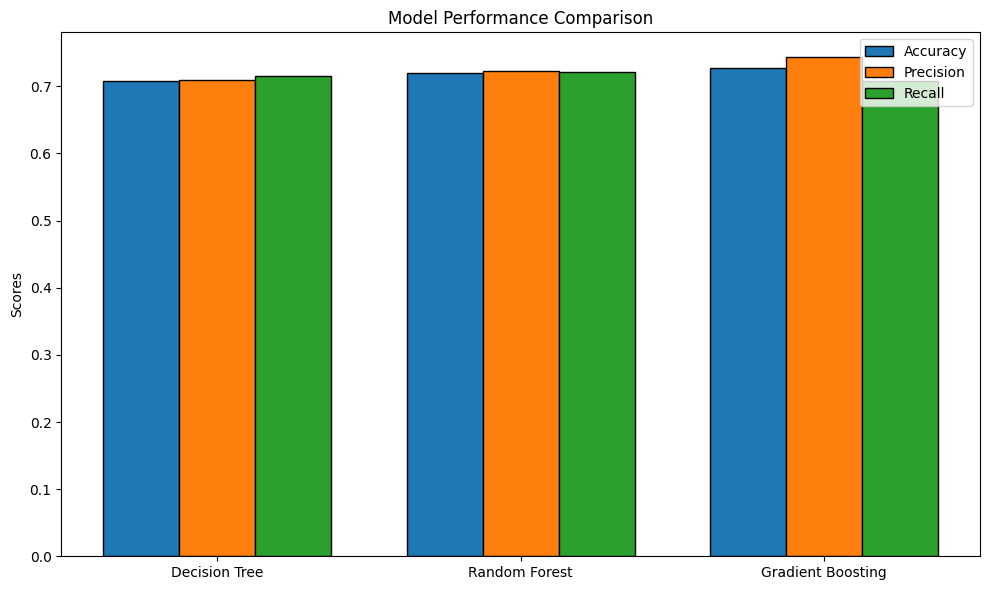

In [ ]:
import matplotlib.pyplot as plt

# Model names and their performances
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
accuracies = [0.7077, 0.7201, 0.7274]
precisions = [0.7102, 0.7227, 0.7433]
recalls = [0.7153, 0.7207, 0.7073]

# Creating the plots
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25
x = range(len(models))

# Plotting each metric
ax.bar(x, accuracies, width, label='Accuracy', edgecolor='black')
ax.bar([p + width for p in x], precisions, width, label='Precision', edgecolor='black')
ax.bar([p + width*2 for p in x], recalls, width, label='Recall', edgecolor='black')

# Adding labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
